<a href="https://colab.research.google.com/github/kuzhuppillil/nU8E2quXIo33gksu/blob/main/Potential_talents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.text import sent_tokenize
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re

import gensim
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
data = pd.read_csv("/content/drive/Othercomputers/My Laptop/Apziva Projects/Potential Talents/potential-talents - Aspiring human resources - seeking human resources.csv")
data.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [6]:
len(data) - len(data[["job_title","location","connection"]].drop_duplicates())

51

Observation:



*   'fit' column is the target
*   Columns 'job_title' and 'location' are the main text columns, where NLP techniques need to be applied.
*   'connection' column contains the numerics with exepection of some '+' symbols.
* There are lot of duplicates in the data, these duplicates has the same jobtites, location and connection.
* The locations seem to be in different format and contains some spelling mistakes.





# Text Preprocessing:

In [7]:
#create a copy of data without the duplicates and with orignials indexes
data1 = data.drop_duplicates(subset=["job_title","location","connection"]).copy()

In [8]:
#removed the +symbol from the connection and changed the dtype to int
data1["connection"] = data1["connection"].str.replace("+","",regex = True).astype(int)

In [9]:
#contents in location column
data1.location.unique()

array(['Houston, Texas', 'Kanada', 'Raleigh-Durham, North Carolina Area',
       'Denton, Texas', 'İzmir, Türkiye', 'Greater New York City Area',
       'San Francisco Bay Area', 'Greater Philadelphia Area',
       'Lake Forest, California', 'Houston, Texas Area',
       'Atlanta, Georgia', 'Chicago, Illinois', 'Austin, Texas Area',
       'Jackson, Mississippi Area', 'Greater Grand Rapids, Michigan Area',
       'Virginia Beach, Virginia', 'Monroe, Louisiana Area',
       'Greater Boston Area', 'San Jose, California',
       'New York, New York', 'Dallas/Fort Worth Area',
       'Amerika Birleşik Devletleri', 'Baton Rouge, Louisiana Area',
       'Myrtle Beach, South Carolina Area', 'Chattanooga, Tennessee Area',
       'Los Angeles, California', 'Highland, California',
       'Gaithersburg, Maryland', 'Baltimore, Maryland',
       'Milpitas, California', 'Greater Atlanta Area',
       'Greater Chicago Area', 'Torrance, California',
       'Long Beach, California', 'Bridgewater, Massa

In [10]:

#fucntion to clean the location text
def text_cleaning(location):

  #contains unnecessary words like 'Area', 'City' and 'Greater, removing them
  location= re.sub("Area","",location)
  location= re.sub("Greater","",location)
  location= re.sub("City","",location)

  #fixing spelling and language check
  location = re.sub("Kanada","Canada",location)
  location = re.sub("Amerika Birleşik Devletleri","United States of America",location)
  location = re.sub("İzmir, Türkiye","izmir, Turkey",location)

  #fixing format
  location = re.sub("Dallas/Fort Worth","Dallas, Fort Worth",location)
  location = re.sub("New York, New York","New York",location)

  #fixing whitespace at start and end of names
  location = re.sub("^\s+|\s+$","",location)

  location = location.lower()

  return location

data1.location = data1.location.apply(lambda x: text_cleaning(x))
data1.location.unique()

array(['houston, texas', 'canada', 'raleigh-durham, north carolina',
       'denton, texas', 'izmir, turkey', 'new york', 'san francisco bay',
       'philadelphia', 'lake forest, california', 'atlanta, georgia',
       'chicago, illinois', 'austin, texas', 'jackson, mississippi',
       'grand rapids, michigan', 'virginia beach, virginia',
       'monroe, louisiana', 'boston', 'san jose, california',
       'dallas, fort worth', 'united states of america',
       'baton rouge, louisiana', 'myrtle beach, south carolina',
       'chattanooga, tennessee', 'los angeles, california',
       'highland, california', 'gaithersburg, maryland',
       'baltimore, maryland', 'milpitas, california', 'atlanta',
       'chicago', 'torrance, california', 'long beach, california',
       'bridgewater, massachusetts', 'lafayette, indiana',
       'kokomo, indiana', 'las vegas, nevada', 'cape girardeau, missouri',
       'los angeles', 'katy, texas'], dtype=object)

In [11]:
#function to clean the text body, tokenization and lemmatization

lemmatizer = WordNetLemmatizer()

def text_process(text):

  #Filtering out the non-alphabets
  text = re.sub(r"[^a-zA-z\'\s]","",text)

  #converted all text to lowercase for consistency
  text = text.lower()

  #Spell check, form check etc
  text = re.sub("hr","human resources",text)
  text = re.sub("hris","human resource information system",text)


  words = nltk.word_tokenize(text)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
  cleaned_text = ' '.join(lemmatized_words)

  return cleaned_text


data1["job_title"] = data1.job_title.apply(lambda x: text_process(x))



resource        38
human           37
aspiring        13
professional    10
seeking         10
manager          7
student          6
university       6
management       5
business         5
dtype: int64


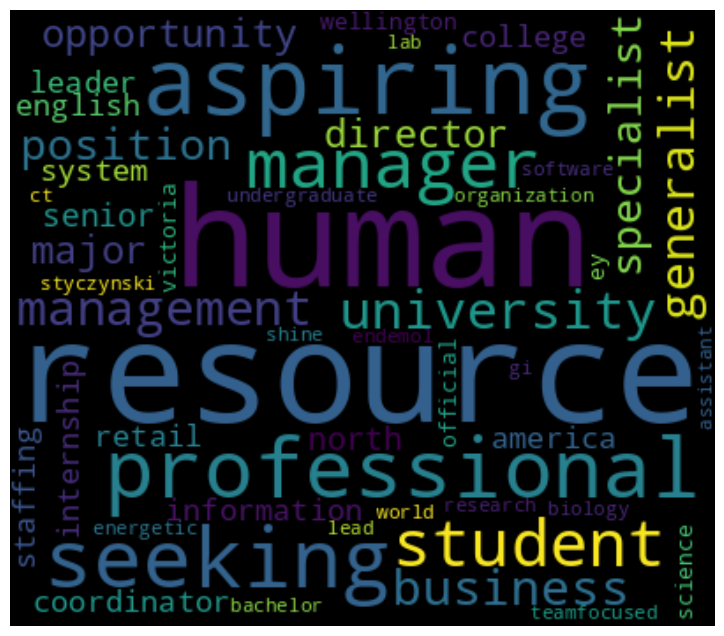

In [16]:
#Frequency count of words

def freq(text):
  word_list = []

  for word in text.str.split():
    word_list.extend(word)
  freq_word = pd.Series(word_list).value_counts()

  return freq_word

word_freq = freq(data1.job_title)


print(word_freq[:10])


wc =  WordCloud(width = 400, height = 350, max_words= 50, background_color= 'black').generate_from_frequencies(word_freq)
plt.figure(figsize =(12,8))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis('off')
plt.show()


# BOW

In [17]:

#Bag Of Words

cv = CountVectorizer(ngram_range=(1,2),max_features=10)

keywords = ["aspiring human resources"]


X=cv.fit_transform(data1.job_title)
keyword_vectors = cv.transform(keywords)

similarity_scores = cosine_similarity(keyword_vectors, X)
data1['fit_BOW'] = similarity_scores.max(axis=0)

data1 = data1.sort_values(by='fit_BOW', ascending=False)

data1.head(50)

,id,job_title,location,connection,fit,fit_BOW
78,79,liberal art major aspiring human resource analyst,"baton rouge, louisiana",7,NaN,0.774597
5,6,aspiring human resource specialist,new york,1,NaN,0.774597
6,7,student humber college aspiring human resource...,canada,61,NaN,0.774597
71,72,business management major aspiring human resou...,"monroe, louisiana",5,NaN,0.707107
26,27,aspiring human resource management student see...,"houston, texas",500,NaN,0.707107
0,1,ct bauer college business graduate magna cum l...,"houston, texas",85,NaN,0.654654
81,82,aspiring human resource professional energetic...,"austin, texas",174,NaN,0.654654
2,3,aspiring human resource professional,"raleigh-durham, north carolina",44,NaN,0.654654
75,76,aspiring human resource professional passionat...,new york,212,NaN,0.654654
96,97,aspiring human resource professional,"kokomo, indiana",71,NaN,0.654654


#TF-IDF

In [18]:
#TF-IDF
tiv = TfidfVectorizer(ngram_range=(1,2),max_features = 10)


keywords = ["aspiring human resources"]

X = tiv.fit_transform(data1.job_title)
keyword_vectors = tiv.transform(keywords)

similarity_scores = cosine_similarity(keyword_vectors, X)
data1['fit_TFIDF'] = similarity_scores.max(axis=0)

data1 = data1.sort_values(by='fit_TFIDF', ascending=False)

data1.head(50)

,id,job_title,location,connection,fit,fit_BOW,fit_TFIDF
78,79,liberal art major aspiring human resource analyst,"baton rouge, louisiana",7,NaN,0.774597,0.874475
6,7,student humber college aspiring human resource...,canada,61,NaN,0.774597,0.874475
5,6,aspiring human resource specialist,new york,1,NaN,0.774597,0.874475
26,27,aspiring human resource management student see...,"houston, texas",500,NaN,0.707107,0.741207
71,72,business management major aspiring human resou...,"monroe, louisiana",5,NaN,0.707107,0.715395
0,1,ct bauer college business graduate magna cum l...,"houston, texas",85,NaN,0.654654,0.643466
81,82,aspiring human resource professional energetic...,"austin, texas",174,NaN,0.654654,0.643466
2,3,aspiring human resource professional,"raleigh-durham, north carolina",44,NaN,0.654654,0.643466
75,76,aspiring human resource professional passionat...,new york,212,NaN,0.654654,0.643466
96,97,aspiring human resource professional,"kokomo, indiana",71,NaN,0.654654,0.643466


# Observations:

**BOW**:
*   Not able to capture any fitness score when using trigrams alone.
*   Able to identify all when using combination of unigram and bigram
*   It's identifying only based on the word combination, unable to capture the semantic




**TF-IDF**: (Slightly better than BOW)

*   Gives the best score when using bigrams along with max_feature restriction of 10, but some of the key words are not getting identfied
*   the fit column contain the score of ngram (1,2) - both uni and bigram in order to identify all titles with keywords.
*   Since TF-IDF using the the concept of rare words, athough it captures the word importance but in our case the search keywords are the most frequent.








# Word2Vec

In [20]:

keywords = "aspiring human resources"

# Tokenizing job titles
vocab = [text.split() for text in data1.job_title]

# Training Word2Vec model using the vocabulary
w2v = Word2Vec(vocab, window=3, min_count=3)

# Getting vectors for keywords
keyword_vectors = [w2v.wv[word] for word in word_tokenize(keywords) if word in w2v.wv.index_to_key]
keyword_vectors = np.mean(keyword_vectors, axis=0).reshape(1, -1)

def avg_word2vec(text):
    words = [word for word in text.split() if word in w2v.wv.index_to_key]
    if not words:
        return np.zeros(w2v.vector_size)
    return np.mean([w2v.wv[word] for word in words], axis=0)

X = [avg_word2vec(text) for text in data1.job_title]


similarity_scores = cosine_similarity(keyword_vectors, X)
data1['fit_Word2Vec'] = similarity_scores[0]
data1 = data1.sort_values(by='fit_Word2Vec', ascending=False)
data1.head(50)



,id,job_title,location,connection,fit,fit_BOW,fit_TFIDF,fit_Word2Vec
81,82,aspiring human resource professional energetic...,"austin, texas",174,NaN,0.654654,0.643466,0.730428
75,76,aspiring human resource professional passionat...,new york,212,NaN,0.654654,0.643466,0.730428
96,97,aspiring human resource professional,"kokomo, indiana",71,NaN,0.654654,0.643466,0.730428
2,3,aspiring human resource professional,"raleigh-durham, north carolina",44,NaN,0.654654,0.643466,0.730428
78,79,liberal art major aspiring human resource analyst,"baton rouge, louisiana",7,NaN,0.774597,0.874475,0.689423
5,6,aspiring human resource specialist,new york,1,NaN,0.774597,0.874475,0.681667
65,66,experienced retail manager aspiring human reso...,"austin, texas",57,NaN,0.612372,0.571530,0.647109
6,7,student humber college aspiring human resource...,canada,61,NaN,0.774597,0.874475,0.646644
72,73,aspiring human resource manager seeking intern...,"houston, texas",7,NaN,0.577350,0.588830,0.645639
0,1,ct bauer college business graduate magna cum l...,"houston, texas",85,NaN,0.654654,0.643466,0.637723


Observation:


*   Word2Vec is the best encoding techinique so far as it is also able to capture the sematic meaning and provide a better fit score using cosine smiliarity.

